In [1]:
!pip install -q mlflow

In [2]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

# Dataset
### Montgomery and Shenzhen for train
https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

### Random NIH for test
https://www.kaggle.com/nih-chest-xrays/sample

In [3]:
image_path_train = '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/'
mask_path_train = '../input/chest-xray-masks-and-labels/Lung Segmentation/masks/'
image_path_test = '../input/sample/sample/sample/images/' 

### images
* 'CHNCXR_0242_0.png'
* 'MCUCXR_0017_0.png'

### mask
* 'MCUCXR_0017_0.png'
* 'CHNCXR_0337_1_mask.png'

### test
* '00006199_010.png'

In [4]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:", len(check))

Total mask that has modified name: 566


In [6]:
testing_files = set(os.listdir(image_path_train)) & set(os.listdir(mask_path_train))
training_files = check

In [7]:
def getData(X_shape, flag = "MONT"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "MONT":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i))
            im = cv2.resize(im, shape)[:, :, 0]
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "SHEN":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i.split("_mask")[0] + ".png"))
            im = cv2.resize(im, shape)[:, :, 0]
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i + ".png"))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    # return list
    return im_array, mask_array

In [8]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i))
        im = cv2.resize(im, shape)[:, :, 0]
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

In [9]:
dim, n_samples = 256, 150 # n_samples = [1, 5606]

image_shen, mask_shen = getData(dim, flag = "SHEN")
image_mont, mask_mont = getData(dim, flag = "MONT")
X_test = get_test(dim, n_samples = n_samples)

100%|██████████| 150/150 [00:04<00:00, 36.37it/s]


In [10]:
image_shen = np.array(image_shen).reshape(len(image_shen), dim, dim, 1)
mask_shen = np.array(mask_shen).reshape(len(mask_shen), dim, dim, 1)

image_mont = np.array(image_mont).reshape(len(image_mont), dim, dim, 1)
mask_mont = np.array(mask_mont).reshape(len(mask_mont), dim, dim, 1)

X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

In [11]:
print(image_shen.shape, mask_shen.shape)
print(image_mont.shape, mask_mont.shape)
print(X_test.shape)

(566, 256, 256, 1) (566, 256, 256, 1)
(138, 256, 256, 1) (138, 256, 256, 1)
(150, 256, 256, 1)


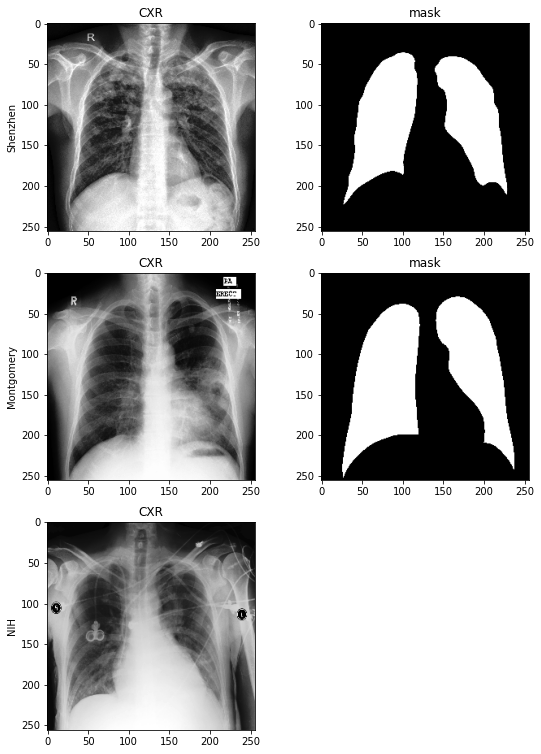

In [12]:
i = 25
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(image_shen[i], cmap='gray')
axs[0, 1].imshow(mask_shen[i], cmap='gray')
axs[0, 0].set_ylabel('Shenzhen')

axs[1, 0].imshow(image_mont[i], cmap='gray')
axs[1, 1].imshow(mask_mont[i], cmap='gray')
axs[1, 0].set_ylabel('Montgomery')

axs[2, 0].imshow(X_test[i], cmap='gray')
axs[2, 0].set_ylabel('NIH')

axs[0, 0].set_title('CXR')
axs[1, 0].set_title('CXR')
axs[2, 0].set_title('CXR')

axs[0, 1].set_title('mask')
axs[1, 1].set_title('mask')

fig.delaxes(axs[2, 1])

In [13]:
assert image_shen.shape == mask_shen.shape
assert image_mont.shape == mask_mont.shape
images = np.concatenate((image_shen, image_mont), axis=0)
masks  = np.concatenate((mask_shen, mask_mont), axis=0)

print(images.shape, masks.shape)

(704, 256, 256, 1) (704, 256, 256, 1)


In [14]:
X_train, X_val, Y_train, Y_val = train_test_split((images - 127.0) / 127.0, 
                                                  (masks > 127).astype(np.float32), 
                                                  test_size = 0.15, 
                                                  random_state = 2018)
X_testNorm = (X_test - 127.0) / 127.0

In [15]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import mlflow
import mlflow.tensorflow

In [16]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred) 

In [17]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [18]:
mlflow.autolog()

2021/09/20 08:25:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/09/20 08:25:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [19]:
model = unet(input_size=(dim, dim, 1))

In [20]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=35) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [21]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

In [22]:
model.compile(optimizer = Adam(lr = 1e-4), 
              loss = loss, 
              metrics = metrics)

In [23]:
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=16, epochs=80,
                callbacks=callbacks_list)

2021/09/20 08:25:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f57f553360ac48d0b8a3de78b4cd3de7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/80
38/38 [==============================] - 23s 312ms/step - loss: 0.6534 - dice_coef: 0.3468 - jaccard_coef: 0.2099 - binary_accuracy: 0.3598 - precision: 0.2655 - recall: 0.8590 - auc: 0.5907 - val_loss: 0.5627 - val_dice_coef: 0.4372 - val_jaccard_coef: 0.2798 - val_binary_accuracy: 0.2736 - val_precision: 0.2551 - val_recall: 1.0000 - val_auc: 0.7665

Epoch 00001: val_loss improved from inf to 0.56274, saving model to cxr_reg_weights.best.hdf5
Epoch 2/80
38/38 [==============================] - 8s 198ms/step - loss: 0.5248 - dice_coef: 0.4753 - jaccard_coef: 0.3122 - binary_accuracy: 0.5226 - precision: 0.3482 - recall: 0.9689 - auc: 0.7564 - val_loss: 0.4166 - val_dice_coef: 0.5844 - val_jaccard_coef: 0.4130 - val_binary_accuracy: 0.6892 - val_precision: 0.4387 - val_recall: 0.8924 - val_auc: 0.7680

Epoch 00002: val_loss improved from 0.56274 to 0.41660, saving model to cxr_reg_weights.best.hdf5
Epoch 3/80
38/38 [==============================] - 7s 197ms/step - loss: 0.3

2021/09/20 08:36:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.



Epoch 00080: val_loss did not improve from 0.03949


2021/09/20 08:36:21 ERROR mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp_qnmp806/model, flavor: keras)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/mlflow/utils/environment.py", line 212, in infer_pip_requirements
    return _infer_requirements(model_uri, flavor)
  File "/opt/conda/lib/python3.7/site-packages/mlflow/utils/requirements_utils.py", line 256, in _infer_requirements
    _MODULES_TO_PACKAGES = importlib_metadata.packages_distributions()
AttributeError: module 'importlib_metadata' has no attribute 'packages_distributions'


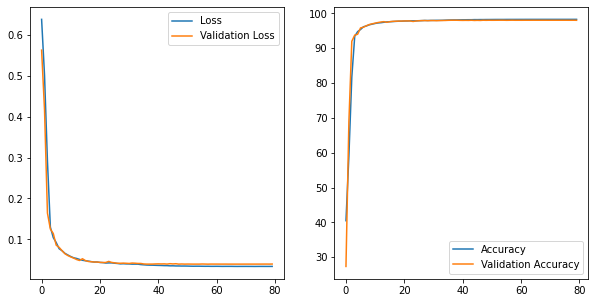

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

In [25]:
preds = model.predict(X_testNorm)

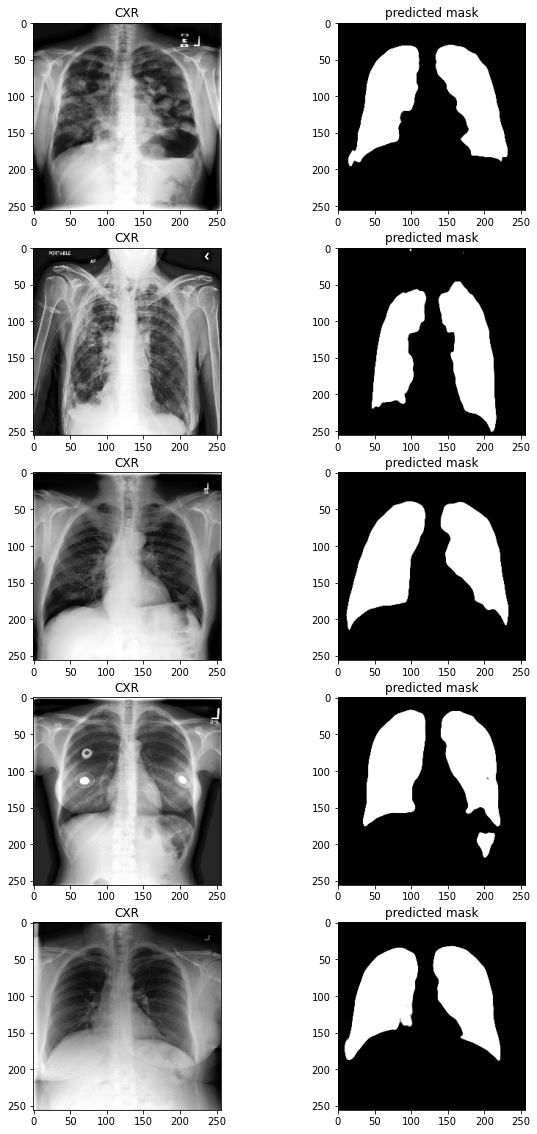

In [26]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i], cmap='gray')
            axs[i, j].set_title('CXR')
        else:
            axs[i, j].imshow(preds[i], cmap='gray')
            axs[i, j].set_title('predicted mask')

In [27]:
model.save('cxr_unet.h5')

In [28]:
from IPython.display import FileLink
FileLink(r'cxr_unet.h5')

/kaggle/working/cxr_unet.h5

In [29]:
!zip -r mlflow_unet.zip ./mlruns

  adding: mlruns/ (stored 0%)
  adding: mlruns/0/ (stored 0%)
  adding: mlruns/0/meta.yaml (deflated 13%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/ (stored 0%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/tags/ (stored 0%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/tags/mlflow.user (stored 0%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/tags/mlflow.log-model.history (deflated 39%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/tags/mlflow.source.name (deflated 2%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/tags/mlflow.autologging (stored 0%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/tags/mlflow.source.type (stored 0%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/params/ (stored 0%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/params/opt_amsgrad (stored 0%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/params/steps_per_epoch (stored 0%)
  adding: mlruns/0/f57f553360ac48d0b8a3de78b4cd3de7/params/patience (stor

In [30]:
from IPython.display import FileLink
FileLink(r'./mlflow_unet.zip')

/kaggle/working/mlflow_unet.zip